In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


In [2]:
def color_transfer(source, target, clip=True, preserve_paper=True):
	"""
	Transfers the color distribution from the source to the target
	image using the mean and standard deviations of the L*a*b*
	color space.
	This implementation is (loosely) based on to the "Color Transfer
	between Images" paper by Reinhard et al., 2001.
	Parameters:
	-------
	source: NumPy array
		OpenCV image in BGR color space (the source image)
	target: NumPy array
		OpenCV image in BGR color space (the target image)
	clip: Should components of L*a*b* image be scaled by np.clip before 
		converting back to BGR color space?
		If False then components will be min-max scaled appropriately.
		Clipping will keep target image brightness truer to the input.
		Scaling will adjust image brightness to avoid washed out portions
		in the resulting color transfer that can be caused by clipping.
	preserve_paper: Should color transfer strictly follow methodology
		layed out in original paper? The method does not always produce
		aesthetically pleasing results.
		If False then L*a*b* components will scaled using the reciprocal of
		the scaling factor proposed in the paper.  This method seems to produce
		more consistently aesthetically pleasing results 
	Returns:
	-------
	transfer: NumPy array
		OpenCV image (w, h, 3) NumPy array (uint8)
	"""
	# convert the images from the RGB to L*ab* color space, being
	# sure to utilizing the floating point data type (note: OpenCV
	# expects floats to be 32-bit, so use that instead of 64-bit)
	source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
	target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

	# compute color statistics for the source and target images
	(lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
	(lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)

	# subtract the means from the target image
	(l, a, b) = cv2.split(target)
	l -= lMeanTar
	a -= aMeanTar
	b -= bMeanTar

	if preserve_paper:
		# scale by the standard deviations using paper proposed factor
		l = (lStdTar / lStdSrc) * l
		a = (aStdTar / aStdSrc) * a
		b = (bStdTar / bStdSrc) * b
	else:
		# scale by the standard deviations using reciprocal of paper proposed factor
		l = (lStdSrc / lStdTar) * l
		a = (aStdSrc / aStdTar) * a
		b = (bStdSrc / bStdTar) * b

	# add in the source mean
	l += lMeanSrc
	a += aMeanSrc
	b += bMeanSrc

	# clip/scale the pixel intensities to [0, 255] if they fall
	# outside this range
	l = _scale_array(l, clip=clip)
	a = _scale_array(a, clip=clip)
	b = _scale_array(b, clip=clip)

	# merge the channels together and convert back to the RGB color
	# space, being sure to utilize the 8-bit unsigned integer data
	# type
	transfer = cv2.merge([l, a, b])
	transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)
	
	# return the color transferred image
	return transfer

def image_stats(image):
	"""
	Parameters:
	-------
	image: NumPy array
		OpenCV image in L*a*b* color space
	Returns:
	-------
	Tuple of mean and standard deviations for the L*, a*, and b*
	channels, respectively
	"""
	# compute the mean and standard deviation of each channel
	(l, a, b) = cv2.split(image)
	(lMean, lStd) = (l.mean(), l.std())
	(aMean, aStd) = (a.mean(), a.std())
	(bMean, bStd) = (b.mean(), b.std())

	# return the color statistics
	return (lMean, lStd, aMean, aStd, bMean, bStd)
def _min_max_scale(arr, new_range=(0, 255)):
	"""
	Perform min-max scaling to a NumPy array
	Parameters:
	-------
	arr: NumPy array to be scaled to [new_min, new_max] range
	new_range: tuple of form (min, max) specifying range of
		transformed array
	Returns:
	-------
	NumPy array that has been scaled to be in
	[new_range[0], new_range[1]] range
	"""
	# get array's current min and max
	mn = arr.min()
	mx = arr.max()

	# check if scaling needs to be done to be in new_range
	if mn < new_range[0] or mx > new_range[1]:
		# perform min-max scaling
		scaled = (new_range[1] - new_range[0]) * (arr - mn) / (mx - mn) + new_range[0]
	else:
		# return array if already in range
		scaled = arr

	return scaled

def _scale_array(arr, clip=True):
	"""
	Trim NumPy array values to be in [0, 255] range with option of
	clipping or scaling.
	Parameters:
	-------
	arr: array to be trimmed to [0, 255] range
	clip: should array be scaled by np.clip? if False then input
		array will be min-max scaled to range
		[max([arr.min(), 0]), min([arr.max(), 255])]
	Returns:
	-------
	NumPy array that has been scaled to be in [0, 255] range
	"""
	if clip:
		scaled = np.clip(arr, 0, 255)
	else:
		scale_range = (max([arr.min(), 0]), min([arr.max(), 255]))
		scaled = _min_max_scale(arr, new_range=scale_range)

	return scaled

In [3]:
def create_mosaic(img_path):
    # read img
    img = cv2.imread(img_path)
    # convert to rgb
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
img_bg_path = '../test_imgs/bg.jpg'
img_fg_path = '../test_imgs/shoe.jpg'

In [5]:
# read imgs
img_bg = cv2.imread(img_bg_path)
img_fg = cv2.imread(img_fg_path)
img_chunk = cv2.resize(img_bg, img_fg.shape[:2])
### TODO: sistemare color transfer ###
# convert to rgb
# img_bg_rgb = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
# img_fg_rgb = cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB)
# convert imgs to ycbcr
# img_bg_ycbcr = cv2.cvtColor(img_chunk, cv2.COLOR_BGR2YCrCb)
# img_fg_ycbcr = cv2.cvtColor(img_fg, cv2.COLOR_BGR2YCrCb)
# compute mean
# mean_bg = np.mean(img_bg_ycbcr, axis=0)
# mean_fg = np.mean(img_fg_ycbcr, axis=0)
# compute stds
# std_bg = np.std(img_bg_ycbcr, axis=0)
# std_fg = np.std(img_fg_ycbcr, axis=0)
# color transfer for cb cr channels
# for ch in range(1,2):
#     img_fg_ycbcr[:,:,ch] = (img_fg_ycbcr[:,:,ch] - mean_fg[:,ch])/std_fg[:,ch]*std_bg[:,ch] + mean_bg[:,ch]
# convert back to RGB the new image
# img_final = cv2.cvtColor(img_fg_ycbcr, cv2.COLOR_YCrCb2RGB)



In [7]:
img_bg_path = '../test_imgs/bg_2.jpg'
img_fg_path = '../test_imgs/shoe.jpg'
mask_path = '../test_imgs/shoe_mask.bmp'

In [8]:
# read imgs
img_bg = cv2.imread(img_bg_path)
img_fg = cv2.imread(img_fg_path)
mask = cv2.imread(mask_path)
# resize background
img_bg = cv2.resize(img_bg, img_fg.shape[:2])
# resize window
window_size = 25
img_fg_resized = cv2.resize(img_fg, (window_size, window_size))
# get dimensions
h = img_bg.shape[0]
w = img_bg.shape[1]
# color transfer on each window
for i in range(0, h, window_size):
    for j in range(0, w, window_size):
        window = img_bg[i:(i+window_size), j:(j+window_size), :]
        img_bg[i:(i+window_size), j:(j+window_size), :] = color_transfer(window, img_fg_resized)
# convert back to RGB
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
# apply mask
img_final = img_bg.copy()
img_final[np.where(mask == 255)] = img_fg[np.where(mask == 255)]


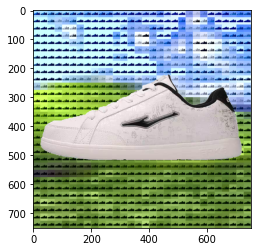

In [9]:
plt.imshow(img_final)

In [282]:
mask = cv2.imread(mask_path)
img_final = img_bg.copy()